In [161]:
%%capture
!pip install wordsegment
!pip install stanfordnlp

In [162]:
from wordsegment import load, segment
load()

In [163]:
# This Python 3 environment comes with many helpful analytics libraries installed
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [164]:
import re
import string
import nltk
#nltk.download('all')
import stanfordnlp
from nltk.corpus import stopwords

In [165]:
import textblob
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from functools import reduce
import operator
import collections
from collections import Counter
import datetime as dt
import seaborn as sns

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [166]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [167]:
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

## Dataset

I scrapped LinkedIn job descriptions for two positions name Data Scientist and Machine Learning Engineer in the United States. Each category has about 1000 job profiles.

In [168]:
test_ds = pd.read_csv('/content/sample_data/job_description_DS.csv')
test_ml = pd.read_csv('/content/sample_data/job_description_ML.csv')
print("\n ** data shape **\n")
print(test_ds.shape)
print(test_ml.shape)


 ** data shape **

(995, 2)
(997, 2)


In [169]:
test_ds = test_ds[test_ds['Description'].notnull()]
test_ml = test_ml[test_ml['Description'].notnull()]

## Text Preprocessing

In [170]:
## Lower case
nltk.download('stopwords')

test_ds['Description'] = test_ds['Description'].apply(lambda x: " ".join(x.lower()for x in x.split()))
test_ml['Description'] = test_ml['Description'].apply(lambda x: " ".join(x.lower()for x in x.split()))
## remove tabulation and punctuation
test_ds['Description'] = test_ds['Description'].str.replace('[^\w\s]',' ')
test_ml['Description'] = test_ml['Description'].str.replace('[^\w\s]',' ')

## digits
test_ds['Description'] = test_ds['Description'].str.replace('\d+', '')
test_ml['Description'] = test_ml['Description'].str.replace('\d+', '')

#remove stop words
stop = stopwords.words('english')

test_ds['Description'] = test_ds['Description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
test_ml['Description'] = test_ml['Description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [171]:
test_ds.to_csv('job_description_DS.csv')
test_ml.to_csv('job_description_ML.csv')

In [172]:
## Delete more stop words not relevant for keyword analysis
other_stop_words = ['job','about','junior','junior','senior','description','experience','etc','job','work','company','technique','full','able',
                    'candidate','skill','skills','language','menu','inc','new','plus','years','disability','people','using','based','world',
                   'technology','organization','ceo','cto','account','manager','mobile','employee','service','customer','client',
                    'including','role','status','developer','opportunity','position','business','product','revenue','strong','eg','help','grow']

test_ds['Description'] = test_ds['Description'].apply(lambda x: " ".join(x for x in x.split() if x not in other_stop_words))
test_ml['Description'] = test_ml['Description'].apply(lambda x: " ".join(x for x in x.split() if x not in other_stop_words))

In [160]:
# prepare corpus from the descriptions that dont have stopwords
job_ds = " ".join(test_ds['Description'].tolist())
job_ml = " ".join(test_ml['Description'].tolist())

ignore_words_segment = ['tensorflow','pytorch','scikit','hadoop']

def segment_words(job_desc):
  new_job_desc = " "
  for words in job_desc.split():
    if words in ignore_words_segment:
      new_words = words
    else:
      segments = segment(words)
      new_words = " ".join(segments)
    new_job_desc = new_job_desc + " " + new_words


  return new_job_desc

corpus_ds = segment_words(job_ds)
corpus_ml = segment_words(job_ml)

In [ ]:
#tokenize words
tokenized_corpus_ds = corpus_ds.split()
tokenized_corpus_ml = corpus_ml.split()

# lemmatize these tokens
#lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokenized_corpus]

# word frequencies for the lemmatized tokens
fd_ds = nltk.FreqDist(tokenized_corpus_ds)
fd_ml = nltk.FreqDist(tokenized_corpus_ml)

# get the top words
top_words = []
for key, value in fd_ml.items():
    top_words.append((key, value))

# sort the list by the top frequencies
top_words = sorted(top_words, key = lambda x:x[1], reverse = True)

# keep top 10 words only
top_words = top_words[:10]
top_words

In [174]:
# and get a list of all the bi-grams and tri-grams
from nltk.util import ngrams # function for making ngrams
esBigrams_ds = ngrams(corpus_ds.split(), 2)
esBigrams_ml = ngrams(corpus_ml.split(), 2)

In [175]:
# get the frequency of each bigram in our corpus
esBigramFreq_ds = collections.Counter(esBigrams_ds)
esBigramFreq_ml = collections.Counter(esBigrams_ml)

In [176]:
## Join bigram tokens with '_' + maintain sorting
ngram_joined_ds = {'_'.join(k):v for k,v in sorted(esBigramFreq_ds.items(), key=lambda item:item[1],reverse=True)}
ngram_joined_ml = {'_'.join(k):v for k,v in sorted(esBigramFreq_ml.items(), key=lambda item:item[1],reverse=True)}


In [177]:
# Filter out terms that are sometimes abbreviated
similar_words = [['computer_science','cs'],['electrical_engineering','ee'],['google_cloud','gcp'],['artificial_intelligence','ai'],['applied_mathematics','applied_maths'],['scikit_learn','sklearn']]

def join_similar_words(gram_dic,word_dic,similar_words):
  for word_duo in similar_words:
    new_stat=0
    if word_duo[0] in list(gram_dic.keys()):
      new_stat = gram_dic[word_duo[0]] + word_dic[word_duo[1]]
      gram_dic[word_duo[0]] = new_stat

  return gram_dic

ngram_joined_ds = join_similar_words(ngram_joined_ds,fd_ds,similar_words)
ngram_joined_ml = join_similar_words(ngram_joined_ml,fd_ml,similar_words)


In [179]:
subject_list = ['computer_science','mathematics','physics','economics','applied_mathematics','software_engineering','electrical_engineering']
degree_level = ['bachelor','master','phd']


In [180]:
def plot_histogram(feat_list,list_name,orientation,word_freq):
  '''
  The code defines a function named 'plot_histogram' that takes in four arguments: 'feat_list', 'list_name', 'orientation', and 'word_freq'.

  'feat_list' is a list of features to plot on the histogram.

  'list_name' is the label for the y-axis of the histogram.

  'orientation' determines whether the histogram will be displayed horizontally or vertically.

  'word_freq' is a dictionary that contains the frequency of each word.
  '''
  feat_sort = []
  for keys,values in dict(word_freq).items():
    if keys in feat_list:
      feat_sort.append((keys,values))
  for keys_bi,values_bi in ngram_joined_ds.items():
    if keys_bi in feat_list:
      feat_sort.append((keys_bi,values_bi))
  
  # Sort the list in decreasing order
  feat_sort.sort(key=lambda a: a[1],reverse=True)
  feat_dict = dict((x, y) for x, y in feat_sort)

  ## Convert to Pandas series for easy plotting
  features = pd.DataFrame(feat_dict.items(), columns=['Features', 'Frequency'])

  print(features)
  ## Setting figure & ax for plots
  fig, ax = plt.subplots(figsize=(10,10))
  sns.set(style="darkgrid")

  ## Setting plot to horizontal for easy viewing + setting title + display  
  bar_plot = sns.barplot(x=features['Frequency'], y=features['Features'],orient=orientation, ax=ax)
  ax.set(xlabel='Frequency', ylabel=list_name)
  plt.title('Frequency Distribution')
  sns.set(font_scale=2.5)
  plt.show();

In [181]:
def compare_histograms(feat_list,list_name,orientation, word_freq_ds, word_freq_ml, ngram_joined_ds, ngram_joined_ml, palette):
  # Sort features in terms of frequency
  feat_sort = []
  
  for (keys_ds,values_ds)in dict(word_freq_ds).items():

    if keys_ds in feat_list:
      feat_sort.append((keys_ds,[values_ds,word_freq_ml[keys_ds]]))
  
  for (keys_bi_ds,values_bi_ds) in ngram_joined_ds.items():
    if keys_bi_ds in feat_list:
      feat_sort.append((keys_bi_ds,[values_bi_ds,ngram_joined_ml[keys_bi_ds]]))
  
  
  feat_sort.sort(key=lambda a: a[1],reverse=True)
  feat_dict = dict((x, y) for x, y in feat_sort)

  ## Convert to Pandas series for easy plotting
  features = pd.DataFrame({list_name: list(feat_dict.keys()),
                   'Data_Scientist': [feat_dict[keys][0] for keys in feat_dict.keys()],
                   'Machine_Learning_Engineer': [feat_dict[keys][1] for keys in feat_dict.keys()]})
 
  print(features)
  ## Setting figure & ax for plots
  fig, ax = plt.subplots(figsize=(20,10))
  sns.set(style="darkgrid")

  ## Setting plot to horizontal for easy viewing + setting title + display 
  tidy_feat = features.melt(id_vars=list_name).rename(columns=str.title)
  tidy_feat = tidy_feat.rename(columns={"Variable": "Job Positions"})
  bar_plot = sns.barplot(data=tidy_feat,
            x=list_name, y='Value',hue='Job Positions',palette = palette)
  

  for g in bar_plot.patches:
    bar_plot.annotate(format(g.get_height(), '.1f'),
                   (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, -13),
                   textcoords = 'offset points')
  ax.set(xlabel=list_name, ylabel='Frequency')
  plt.legend(loc="upper right", frameon=True, fontsize=20)
  plt.title('Frequency Distribution')
  sns.set(font_scale=2.0)
  plt.xticks(rotation=90)
  plt.show();

                   Majors  Data_Scientist  Machine_Learning_Engineer
0        computer_science             530                        709
1             mathematics             306                        388
2               economics             132                        167
3                 physics             112                        190
4     applied_mathematics              76                        101
5    software_engineering              75                        151
6  electrical_engineering              53                         99


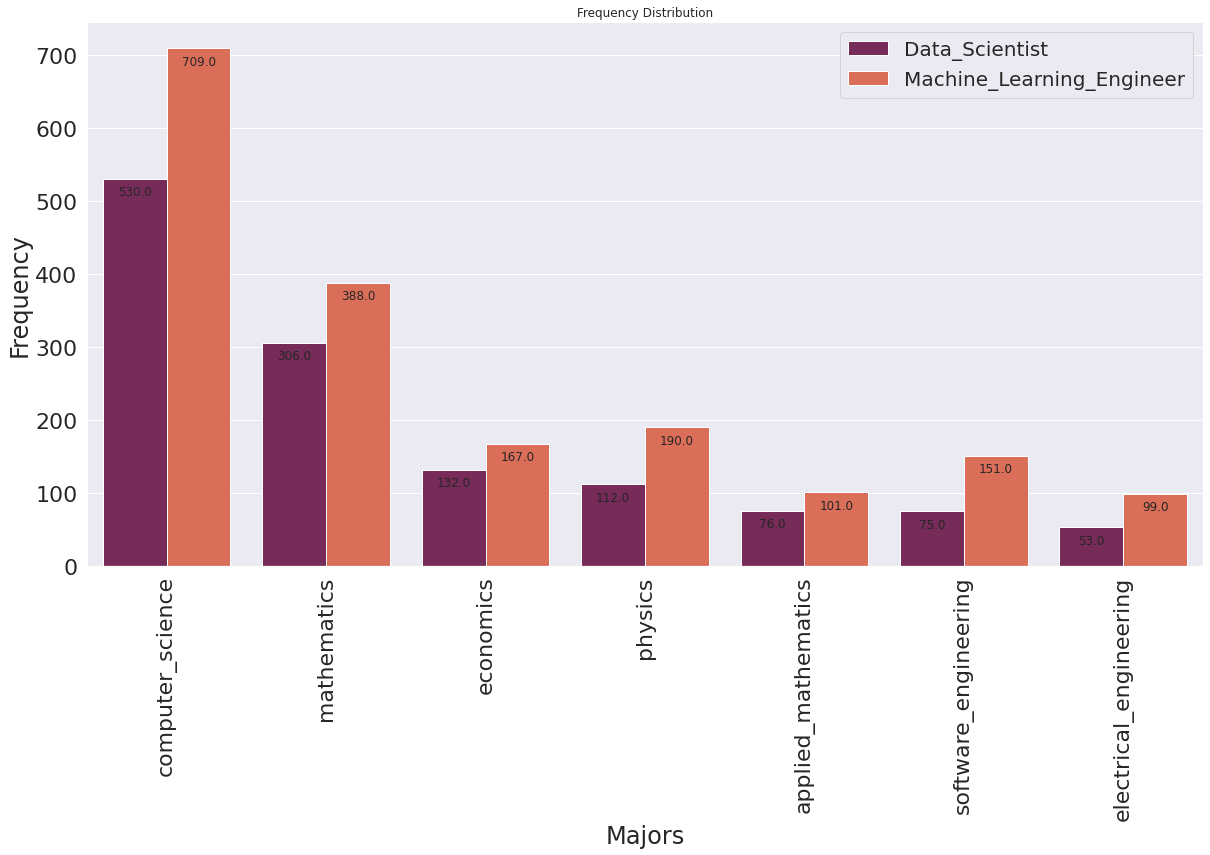

In [182]:
compare_histograms(subject_list,'Majors','v',fd_ds,fd_ml,ngram_joined_ds, ngram_joined_ml, 'rocket')

## Which majors are usually mentioned in the job description?

     Degree  Data_Scientist  Machine_Learning_Engineer
0  bachelor             372                        299
1    master             260                        235
2       phd             229                        363


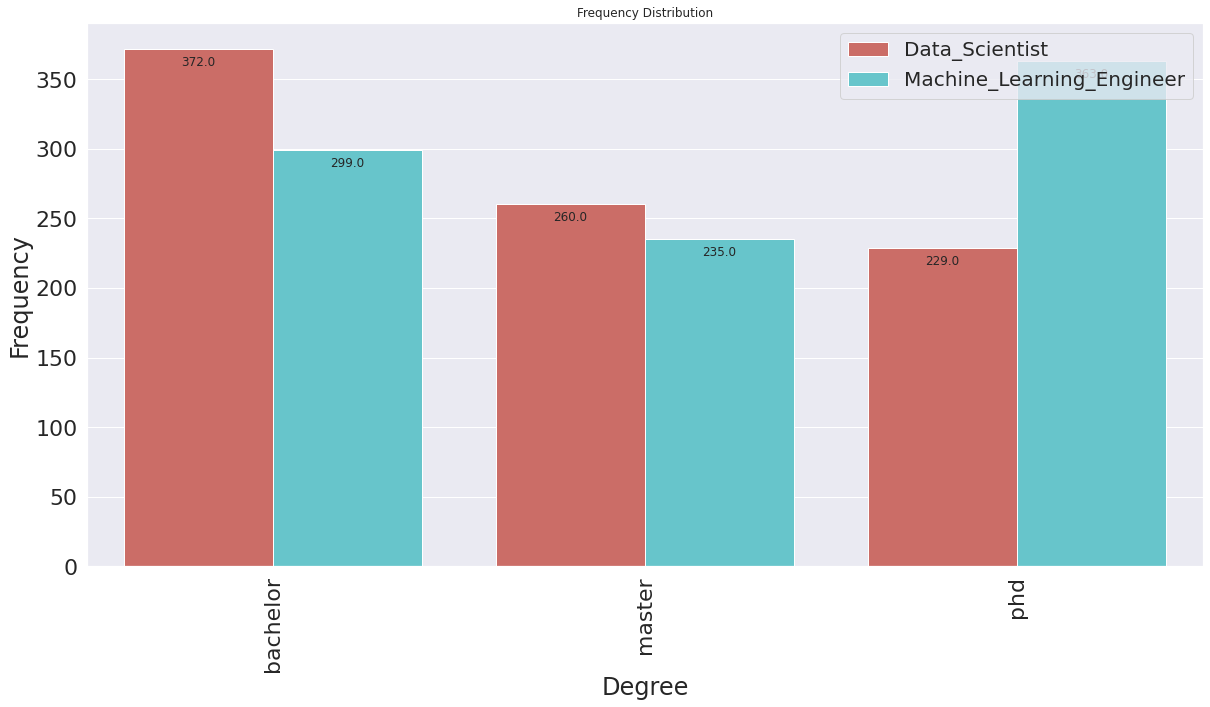

In [183]:
compare_histograms(degree_level,'Degree','v',fd_ds,fd_ml,ngram_joined_ds, ngram_joined_ml, 'hls')

## The most common libraries

  Programming Languages  Data_Scientist  Machine_Learning_Engineer
0                python             856                       1060
1                   sql             742                        447
2                     r             551                        477
3                     c             227                        438
4                  java             109                        148
5                    go              69                         97
6                matlab              40                         58
7                 julia               9                         18


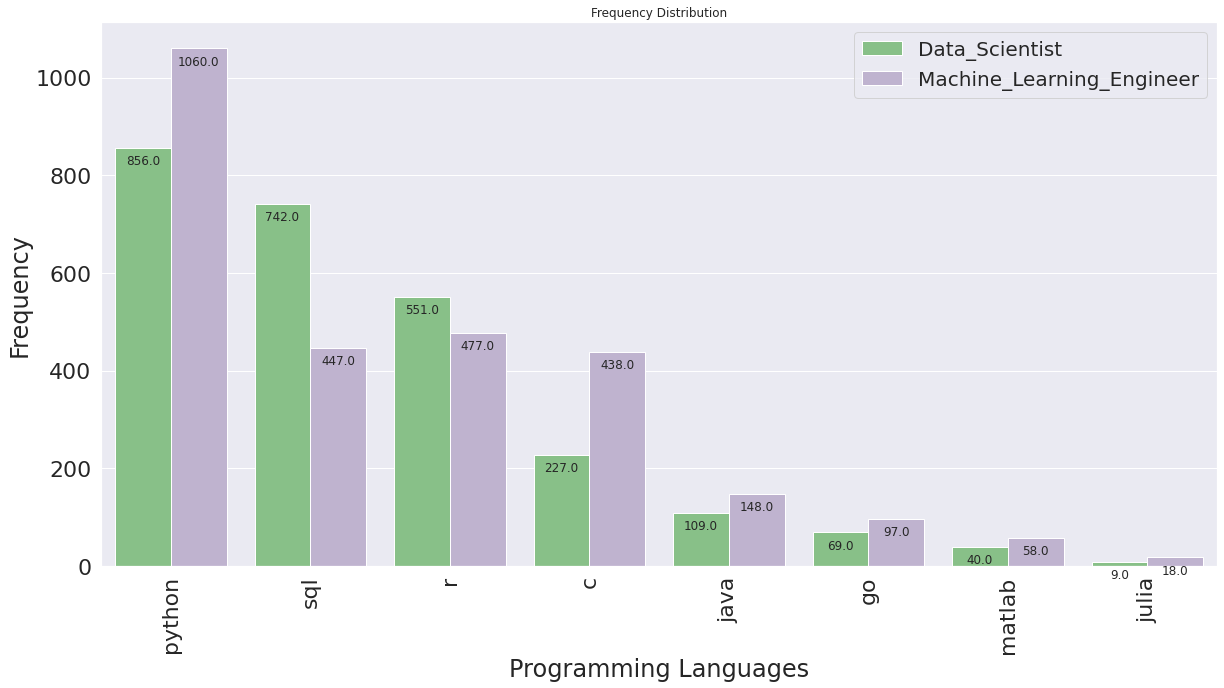

In [184]:
# Most common programming languages (C includes both c and c+)
programming_lang = ['python','java','go','c','sql','r','matlab','julia']
#plot_histogram(programming_lang,'Programming Languages','h',fd_ds)
compare_histograms(programming_lang,'Programming Languages','v',fd_ds,fd_ml,ngram_joined_ds, ngram_joined_ml, 'Accent')

## Which libraries are most commonly used?

  Common Libraries  Data_Scientist  Machine_Learning_Engineer
0          tableau             204                        100
1         power_bi             183                         72
2       tensorflow             103                        396
3           hadoop              90                         80
4           pandas              87                         88
5          pytorch              82                        349
6     scikit_learn              59                        117
7            numpy              58                         73
8       matplotlib              12                         20


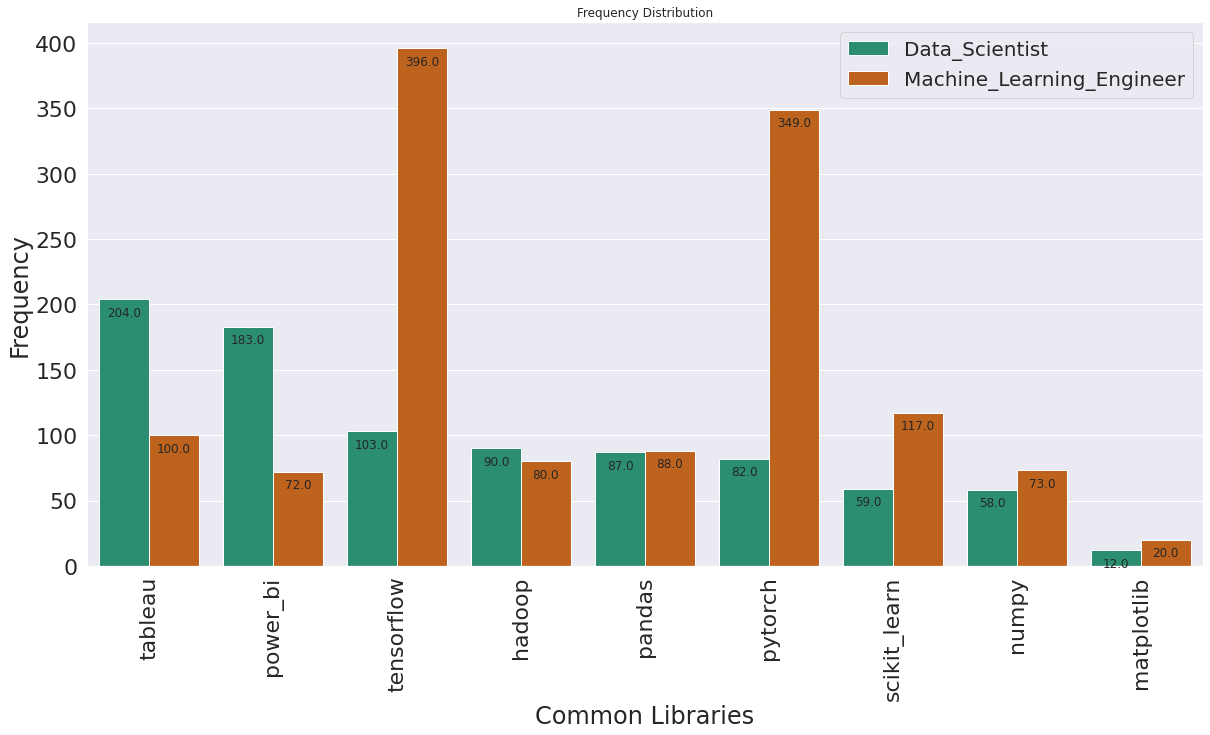

In [185]:
common_libs = ['hadoop','scikit_learn','matplotlib','pandas','numpy','tableau','power_bi','pyspark','tensorflow','pytorch']
compare_histograms(common_libs,'Common Libraries','v',fd_ds,fd_ml,ngram_joined_ds, ngram_joined_ml, 'Dark2')

  Cloud Platforms  Data_Scientist  Machine_Learning_Engineer
0             aws             250                        277
1           azure             224                        129
2    google_cloud             117                        138


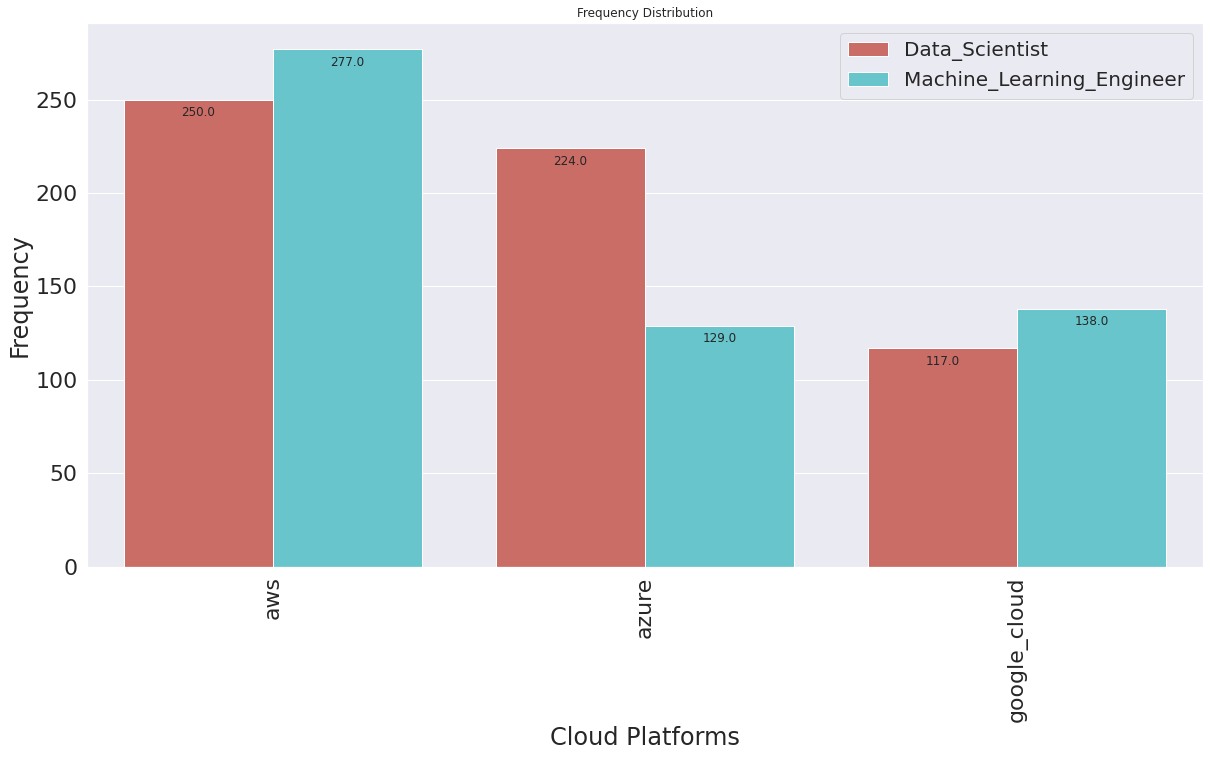

In [186]:
cloud = ['aws','azure','google_cloud']
compare_histograms(cloud,'Cloud Platforms','v',fd_ds,fd_ml,ngram_joined_ds, ngram_joined_ml, 'hls')

## Technical keywords most often mentioned in job descriptions (part 1).

    Technical Keywords  Data_Scientist  Machine_Learning_Engineer
0     machine_learning            1371                       3508
1           algorithms             483                        888
2             database             225                         65
3                  nlp             182                        290
4             big_data             170                        187
5          data_mining             109                        161
6  predictive_modeling              61                        140
7   hypothesis_testing              36                         12
8       decision_trees              31                         22


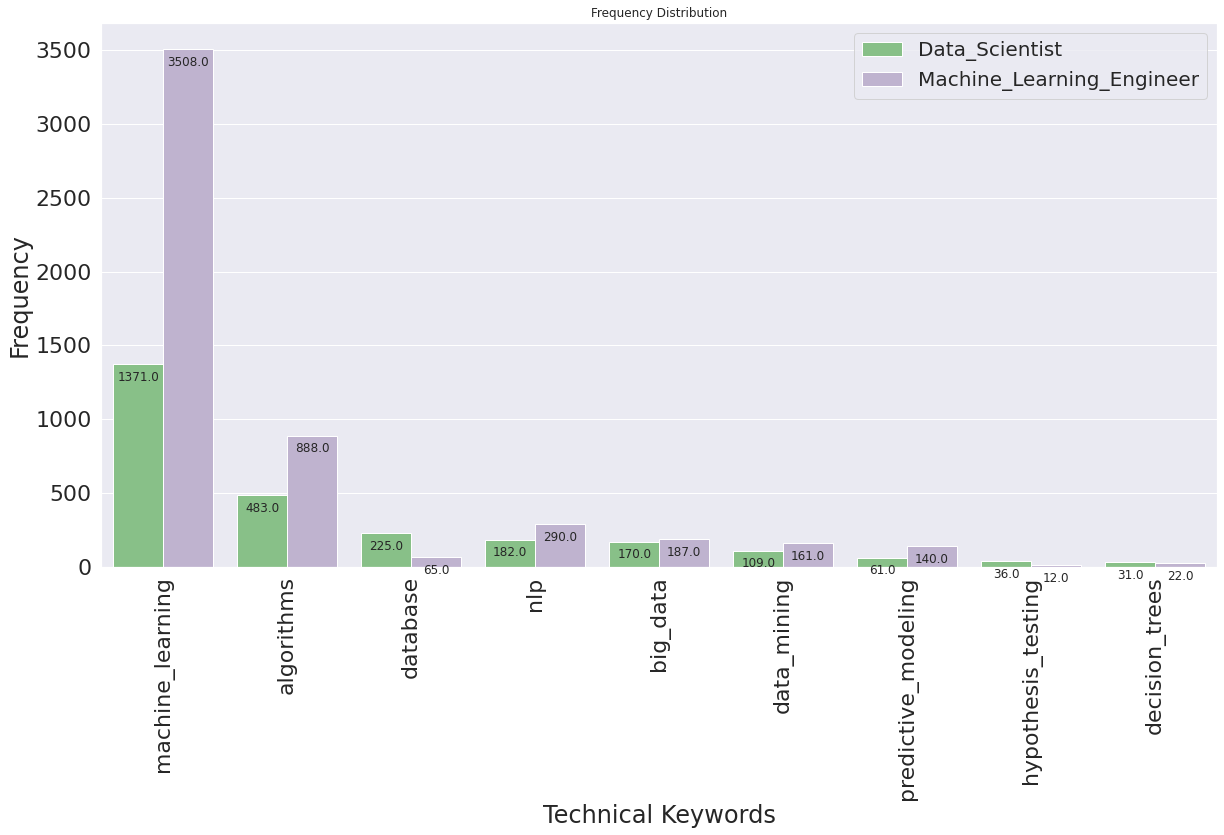

In [187]:
# Technical keywords often mentioned in the job description
keywords_1 = ['algorithms','hypothesis_testing','devops','database','big_data','nlp','data_mining','predictive_modeling','machine_learning','decision_trees']
compare_histograms(keywords_1,'Technical Keywords','v',fd_ds,fd_ml,ngram_joined_ds, ngram_joined_ml, 'Accent')

## Part 2

     Technical Keywords  Data_Scientist  Machine_Learning_Engineer
0         deep_learning             208                        738
1    data_visualization             196                        161
2            regression             128                        160
3                   git             124                        124
4        classification              96                        165
5            clustering              78                         76
6  software_engineering              75                        151
7  statistical_modeling              63                         77
8                docker              49                         97


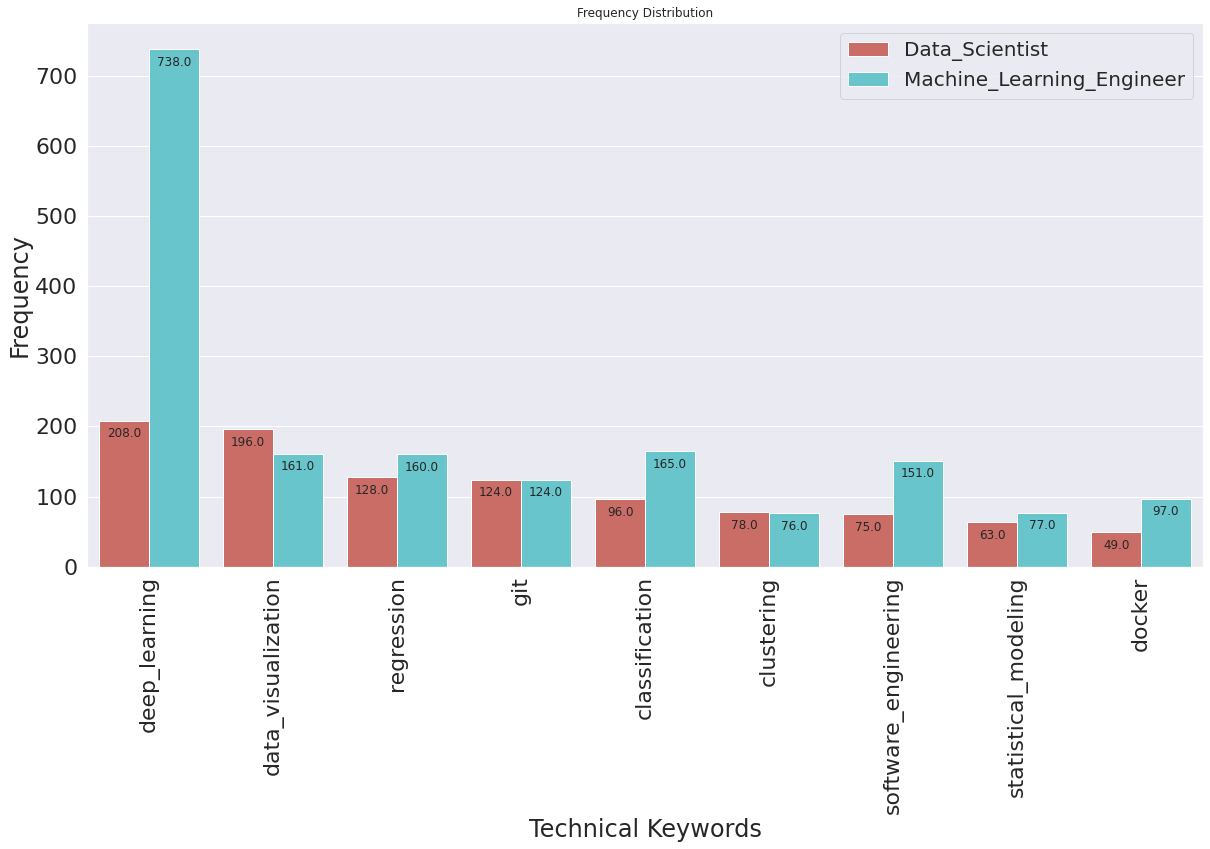

In [188]:
keywords_2 = ['mlops','clustering','classification','regression','git','data_visualization','statistical_modeling','deep_learning','docker','software_engineering']
compare_histograms(keywords_2,'Technical Keywords','v',fd_ds,fd_ml,ngram_joined_ds, ngram_joined_ml, 'hls')

         Soft Skills  Data_Scientist  Machine_Learning_Engineer
0           research            1231                       1648
1      communication             592                        549
2        data_driven             265                        213
3    problem_solving             252                        155
4      collaborative             196                        255
5          curiosity              86                         93
6  critical_thinking              48                         18
7        team_player              42                         32
8    detail_oriented              39                         14
9       storytelling              23                         20


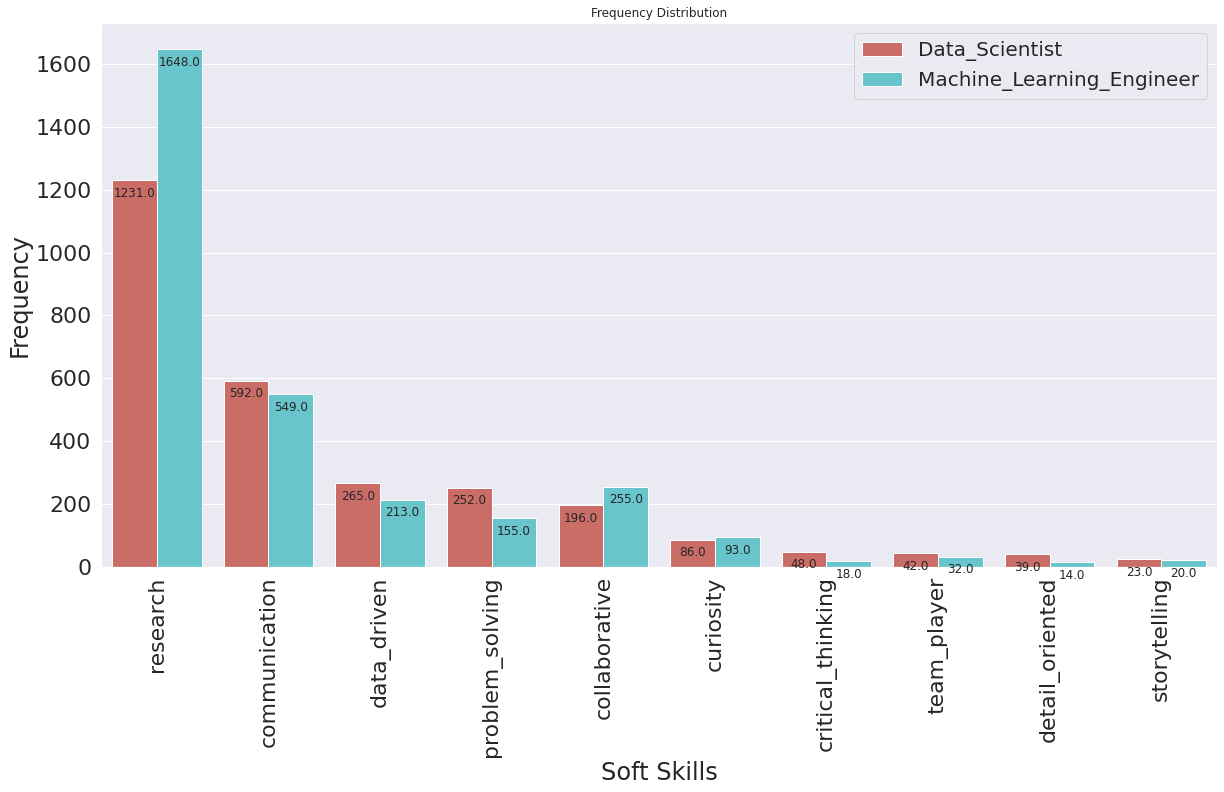

In [189]:
# Technical keywords often mentioned in the job description
soft_skills = ['research','collaborative','detail_oriented','critical_thinking','team_player','communication','problem_solving','storytelling','data_driven','curiosity']
compare_histograms(soft_skills,'Soft Skills','v',fd_ds,fd_ml,ngram_joined_ds, ngram_joined_ml, 'hls')

             Visa Info  Data_Scientist  Machine_Learning_Engineer
0                 visa              39                         24
1   security_clearance              33                         84
2              sponsor              27                         24
3           us_citizen              17                         14
4           green_card              16                          8
5  without_sponsorship               9                          3


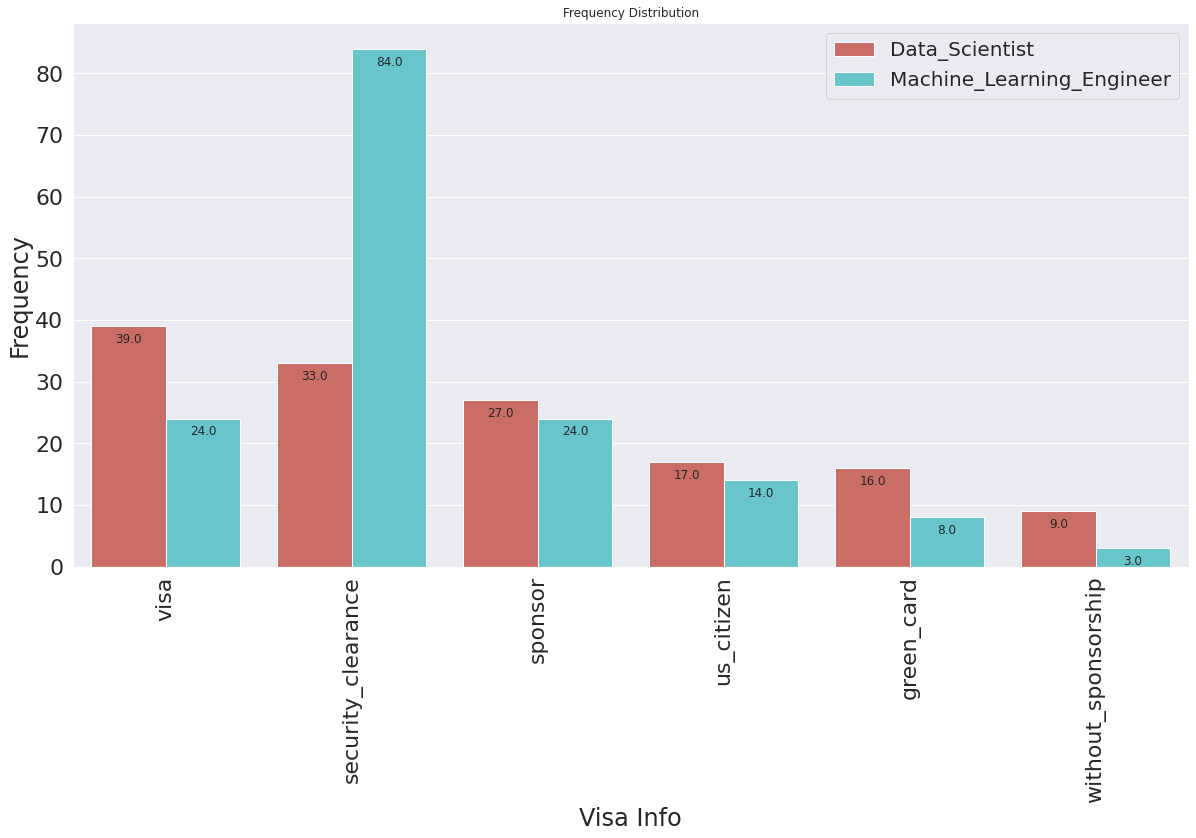

In [190]:
visa_info = ['without_sponsorship','security_clearance','us_citizen','green_card','sponsor','visa']
compare_histograms(visa_info,'Visa Info','v',fd_ds,fd_ml,ngram_joined_ds, ngram_joined_ml, 'hls')

  Work Mode  Data_Scientist  Machine_Learning_Engineer
0    remote             315                        465
1    hybrid             186                        222
2    onsite             101                         93


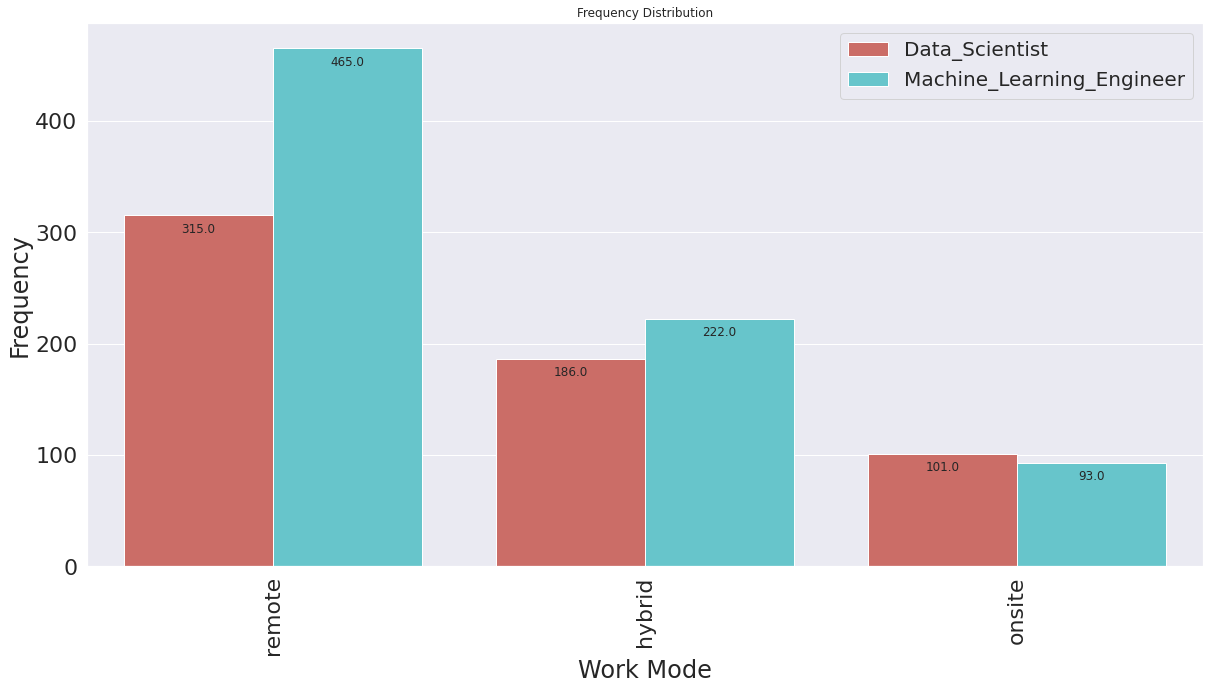

In [191]:
work_loc = ['hybrid','remote','onsite']
compare_histograms(work_loc,'Work Mode','v',fd_ds,fd_ml,ngram_joined_ds, ngram_joined_ml, 'hls')